In [13]:
#First Model
import pandas as pd
import cv2
import numpy as np
from skimage.feature import hog, graycomatrix, graycoprops
from scipy.stats import entropy
from skimage.measure import label, regionprops
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Load the labeled data
labels_df = pd.read_csv('image_labels_original_data_set.csv')
# labels_df = pd.read_csv('image_labels3.csv')
# labels_df = pd.read_csv('image_labels4.csv')
# labels_df = pd.read_csv('image_labels5.csv')
# labels_df = pd.read_csv('image_labels6.csv')
# labels_df = pd.read_csv('image_labels7.csv')
# labels_df = pd.read_csv('image_labels_bigest_data_01.csv')
# labels_df = pd.read_csv('image_labels8.csv')
import numpy as np
import pandas as pd
from skimage.feature import greycomatrix, greycoprops
from scipy.stats import entropy, skew, kurtosis
from skimage.measure import label, regionprops, moments_hu

def extract_features_from_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to read image {image_path}")
        return None

    original_height, original_width = image.shape[:2]

    # Resize the image
    image_resized = cv2.resize(image, (100, 100))

    # Convert to grayscale for some features
    image_gray = cv2.cvtColor(image_resized, cv2.COLOR_RGB2GRAY)
    image_resized_gray = cv2.resize(image_gray, (100, 100))


    # HOG features
    hog_features = hog(image_gray, orientations=8, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), visualize=False)
    hog_mean = np.mean(hog_features)
    hog_std = np.std(hog_features)


    # Texture features from grayscale
    glcm = graycomatrix(image_resized_gray, [5], [0], symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    ASM = graycoprops(glcm, 'ASM')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    entropy_value = entropy(image_resized_gray.ravel())
    mean_intensity = np.mean(image_resized_gray)
    std_intensity = np.std(image_resized_gray)
    skewness_intensity = skew(image_resized_gray.ravel())
    kurtosis_intensity = kurtosis(image_resized_gray.ravel())

    # Shape features
    edges = cv2.Canny(image_gray, 100, 200)
    num_centromeres = len(regionprops(label(edges)))
    chrom_length = original_height - 2
    aspect_ratio = original_height / original_width

    # Hu Moments
    moments = moments_hu(image_gray)
    hu_moments = [m for m in moments]

    # Edge-based features
    # edge_density = np.sum() / (original_height * original_width)
    _, binary_image = cv2.threshold(image_resized_gray, 20, 255, cv2.THRESH_BINARY)

    # Contour-based features
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    total_edge_pixels = np.sum([cv2.contourArea(contour) for contour in contours])
    edge_density = total_edge_pixels / (original_height * original_width)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        perimeter_length = cv2.arcLength(largest_contour, True)
        solidity = cv2.contourArea(largest_contour) / cv2.contourArea(cv2.convexHull(largest_contour))
    else:
        perimeter_length = 1
        solidity = 0


    # Color features
    mean_color = np.mean(image_resized, axis=(0, 1))
    std_color = np.std(image_resized, axis=(0, 1))

    features = {
        'hog_mean': hog_mean,
        'hog_std': hog_std,
        'dissimilarity': dissimilarity,
        'homogeneity': homogeneity,
        'ASM': ASM,
        'energy': energy,
        'correlation': correlation,
        'entropy': entropy_value,
        'mean_intensity': mean_intensity,
        'std_intensity': std_intensity,
        'skewness_intensity': skewness_intensity,
        'kurtosis_intensity': kurtosis_intensity,
        'aspect_ratio': aspect_ratio,
        'edge_density': edge_density,
        'solidity': solidity,
        'mean_color_R': mean_color[0],
        'std_color_R': std_color[0],
    }

    return features
# Extract features for each image
features_list = [extract_features_from_image(path) for path in labels_df['filepath']]

# Remove None values from the features list
features_list = [f for f in features_list if f is not None]

# Create DataFrame from features
features_df = pd.DataFrame(features_list)
features_df['label'] = labels_df.loc[features_df.index, 'label']

# Split the data into features and labels
X = features_df.drop('label', axis=1)
y = features_df['label']
# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train LDA model
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

# Evaluate the model
y_train_pred = lda.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_report = classification_report(y_train, y_train_pred, target_names=['good', 'noise'])

y_test_pred = lda.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred, target_names=['good', 'noise'])

print(f'Training Accuracy: {train_accuracy}')
print(f'Test Accuracy: {test_accuracy}')

print('Training Classification Report:')
print(train_report)

print('Test Classification Report:')
print(test_report)




Training Accuracy: 0.8484848484848485
Test Accuracy: 0.82
Training Classification Report:
              precision    recall  f1-score   support

        good       0.76      0.67      0.71        55
       noise       0.88      0.92      0.90       143

    accuracy                           0.85       198
   macro avg       0.82      0.79      0.80       198
weighted avg       0.84      0.85      0.85       198

Test Classification Report:
              precision    recall  f1-score   support

        good       0.74      0.78      0.76        18
       noise       0.87      0.84      0.86        32

    accuracy                           0.82        50
   macro avg       0.80      0.81      0.81        50
weighted avg       0.82      0.82      0.82        50



In [14]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold Cross-Validation
cv_scores = cross_val_score(lda, X_scaled, y, cv=5)

# Calculate mean and standard deviation of Cross-Validation scores
cv_mean = np.mean(cv_scores)
cv_std = np.std(cv_scores)

# Display Cross-Validation results
print(f'Cross-Validation Accuracy: {cv_mean} ± {cv_std}')


Cross-Validation Accuracy: 0.818530612244898 ± 0.03351475273013759


Cross-Validation Accuracy: 0.81 ± 0.06


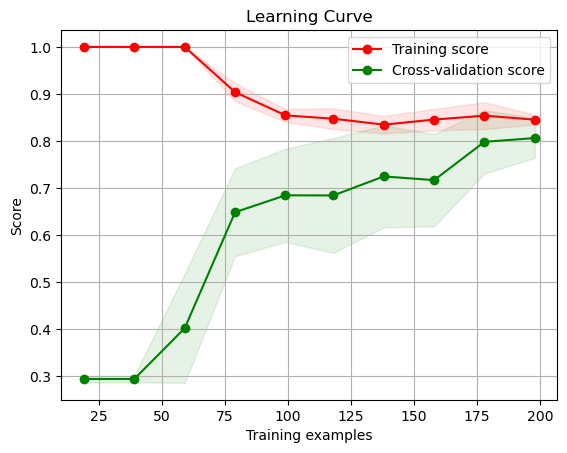

In [16]:
from sklearn.model_selection import cross_val_score, learning_curve

# Cross-validation
cv_scores = cross_val_score(lda, X, y, cv=10)
print(f'Cross-Validation Accuracy: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}')

# Learning curve
train_sizes, train_scores, test_scores = learning_curve(lda, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")
plt.show()


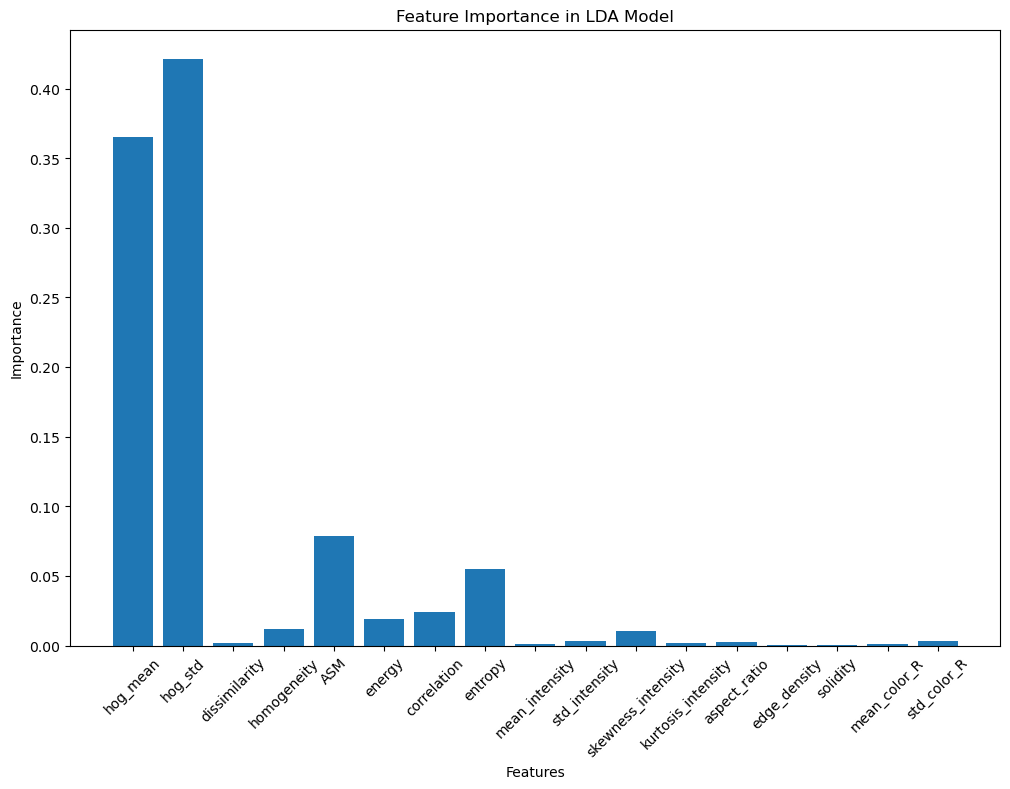

In [11]:
# Plot feature importance
feature_importance = np.abs(lda.coef_[0])
feature_importance_normalized = feature_importance / np.sum(feature_importance)
plt.figure(figsize=(12, 8))
plt.bar(X_scaled_df.columns, feature_importance_normalized)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance in LDA Model')
plt.xticks(rotation=45)
plt.show()